In [1]:
# 房产公司预测区域房价中位线

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# print(HOUSING_URL)
# fetch_housing_data(HOUSING_URL, HOUSING_PATH)


In [3]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data(HOUSING_PATH)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 字段含义
- longitude：经度
- latitude：纬度
- housing_median_age: 房龄
- total_rooms: 房间总数
- total_bedrooms: 卧室数目
- population: 人口
- households: 家庭
- median_income: 收入中位数
- median_housing_value: 房价中位数
- ocean_proximity: 临近？


In [4]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# 数值属性的摘要
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


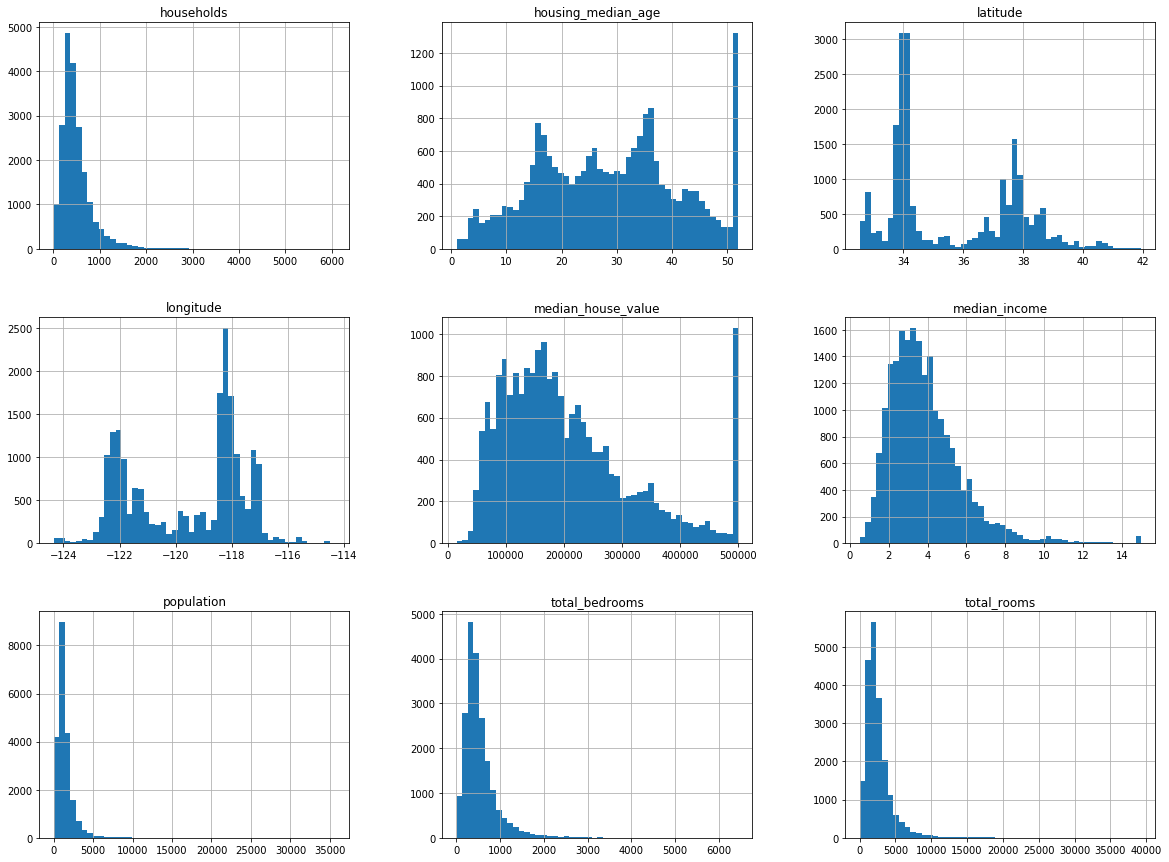

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# 创建测试集
# 该数据集随机，并不完美。最好每次生成的数据集一致（固定）
import numpy as np
def split_train_test(data, test_radio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), " train +", len(test_set), " test")


16512  train + 4128  test


In [9]:
import hashlib
def test_set_check(identifier, test_radio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_radio

def split_train_test_by_id(data, test_radio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_radio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # add index clolumn, 使用index列进行索引
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

housing_with_id['id'] = housing["longitude"] * 1000 + housing["latitude"]  # 使用自定义的id列进行索引拆分
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # 42是常用的种子
test_set.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


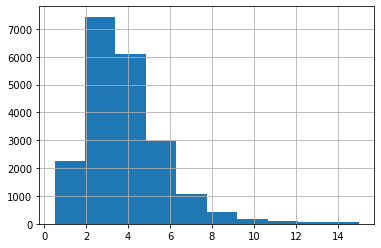

In [10]:
housing["median_income"].hist()

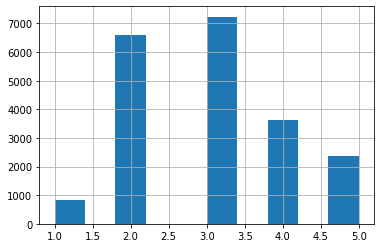

In [11]:
# 收入分类（收入的中位数大致聚集在2-5万左右）
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()



In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
# 看看所有住房数据 根据 收入类别的比例分布
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [14]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [15]:
# 比较不同抽样中，收入的比例是否一致
def income_cat_proportions(data):
    return data["income_cat"].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"]/compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"]/compare_props["Overall"] - 100


In [16]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [17]:
# 恢复数据集
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    

# 从数据探索和可视化中获得洞见

In [18]:
housing = strat_train_set.copy()


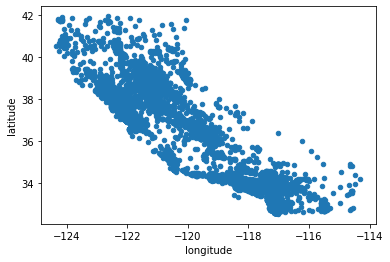

In [19]:
# 将地理数据可视化
housing.plot(kind="scatter", x="longitude", y="latitude")

In [ ]:
# 将alpha属性设置为0.1，更好的看到数据分布
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [ ]:
# s代表人口数量（圆半径），c代表房价（颜色），jet是预置的色模板
housing.plot(kind="scatter", x="longitude", y="latitude", s=housing["population"]/100,label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()

In [ ]:
# 属性间相关系数
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
import matplotlib.image as mpimg
california_img = mpimg.imread("images" + "/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", s=housing["population"]/100,label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize = 16)

plt.legend(fontsize=16)
plt.show()


In [ ]:
# 绘制各个属性间的相关性
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [ ]:
# 最有影响的是收入中位数
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [ ]:
# 几个计算属性
# 每个家庭房间数
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# 卧室数 对比 房间数
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# 每个家庭人口
housing["population_per_household"] = housing["population"]/housing["households"]


In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
# 分离预测数据和标签
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [ ]:
# 处理缺失数据
# 删除空数据
# housing.dropna(subset=["total_bedrooms"])
# housing.drop("total_bedrooms", axis=1)
# 使用中位数填充
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median)

In [ ]:
# 使用sklearn处理缺失值
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

In [ ]:
housing_num.median().values


In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
# 处理文本和分类属性
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
housing_cat_1hot.toarray()

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

In [ ]:
housing.columns

In [ ]:
# 自定义转换器
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [ ]:
# 另外一种自定义转换器
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)


In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

In [ ]:
# 特征缩放：如果数值差异太大，则需要进行缩放，否则机器学习的算法表现不佳
# 同比例缩放一般两种方式：最小-最大缩放（又叫归一法） 和 标准化
# 归一法一般可使用sklearn的MinMaxScaler转换器
# 标准化一般用 StandardScaler
# 缩放器只能用来拟合训练集，而不是完整的数据集（包括测试集）


In [ ]:
# 转化流水线
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr